In [ ]:
!rm -rf /content/mtcnn_extracted_faces/
!unzip /content/mtcnn_extracted_faces.zip
!unzip /content/LFW_Dataset.zip
!pip install --upgrade scikit-learn

In [6]:
# from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from os import listdir
from numpy import load
from numpy import asarray
from numpy import savez_compressed
from sklearn.preprocessing import StandardScaler as StandardScaler_C
from sklearn.preprocessing import MinMaxScaler as MinMaxScaler_C
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier_C
from sklearn.preprocessing import LabelEncoder as LabelEncoder_C
from sklearn.pipeline import Pipeline
from sklearn import metrics as metrics_C
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.svm import LinearSVC
from sklearn.decomposition import IncrementalPCA
import joblib
import pandas as pd
import re
# from mtcnn.mtcnn import MTCNN

In [ ]:
# #########extracts faces from entire LFW dataset using MTCNN #########
''' preprocessing_file = '../mtcnn_extracted_faces/'
from_file = '../LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled/' '''

mtcnn = MTCNN(post_process=False, device=device)
preprocessing_file = './mtcnn_extracted_faces/'
# from_file = './lfw-deepfunneled/'
from_file = '../LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled/'


list_directories = os.listdir(from_file)
for dir in list_directories:
  save_path = preprocessing_file + dir + '/'
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  curr_path = from_file + dir
  curr_files = [curr_path + '/' + image for image in os.listdir(curr_path)]
  for i, curr_img in enumerate(curr_files):
    frame = Image.open(curr_img).convert("RGB")
    face = mtcnn(frame)

    if face is None:
      continue
    img=Image.fromarray(np.uint8(face.permute(1,2,0).int().numpy()))
    save_name = save_path + dir + str(i).zfill(4) + '.jpg'
    img.save(save_name)

In [ ]:
############ Train HOG model #######################
from skimage import data, color, feature, transform
from sklearn.datasets import fetch_lfw_people
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
import math

"""function returns gradient orientations in form of 9 bin histogram for the input window"""
def hog_patch(patch):
    x_grad = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    y_grad = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
    mag, angle = cv2.cartToPolar(x_grad, y_grad)
    hist, bins = np.histogram(angle, bins=9, range=(0, math.pi), weights=mag)
    return hist

"""Fuction return a HOG descriptor for input patch of an image"""
def hog_extractor(face_image):
    # face_image = cv2.cvtColor(face_image, cv.COLOR_BGR2GRAY)
    # face_image = np.sqrt(face_image)
    (h, w) = face_image.shape
    h, w = h//8, w//8
    face_image = cv2.resize(face_image, (w*8, h*8))

    hog_8by8 = []
    for i in range(h):
        r = i*8
        curr_r = []
        for j in range(w):
            c = j*8
            hist = hog_patch(face_image[r:r+8, c:c+8])
            curr_r.append(hist)
        hog_8by8.append(curr_r)

    hog_8by8 = np.array(hog_8by8)
    (h, w, c) = hog_8by8.shape

    hog_16by16 = []
    for i in range(h-1):
        curr_r = []
        for j in range(w-1):
            arr = hog_8by8[i:i+2, j:j+2].flatten()
            norm = np.linalg.norm(arr)
            arr = arr / (norm + 1e-6) if norm > 0 else arr
            curr_r.append(arr)
        hog_16by16.append(curr_r)
    hog_16by16 = np.array(hog_16by16)
    return hog_16by16.flatten()

#Obtain Positive Training Samples
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patch_size = positive_patches[0].shape
print("Shape of positive patches ", positive_patches.shape)
#Obtain Negative Training Samples
imgs_to_use = ['camera', 'text', 'coins', 'moon',
            'page', 'clock', 'immunohistochemistry',
            'chelsea', 'coffee', 'hubble_deep_field']
images = [getattr(data, name)()
        for name in imgs_to_use]
for i in range(len(images)):
    if len(images[i].shape)==3:
        images[i] = color.rgb2gray(images[i])

def extract_patches(img, N, scale=1.0, patch_size=positive_patch_size):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                            max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                        for im in images for scale in [0.5, 1.0, 2.0]])
print("Shape of negative patches ", negative_patches.shape)


#Combine Positive and Negative Samples and compute HOG
X_train = np.array([hog_extractor(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
print("positive negative merged ", X_train.shape)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Training a Support Vector Machine
cross_val_score(GaussianNB(), X_train, y_train)
print("Cross validation score ", cross_val_score(GaussianNB(), X_train, y_train))

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
print("Best score ", grid.best_score_)
print("Best param ", grid.best_params_)

# Get the best hyperparameters
best_params = grid.best_params_
print("Best Hyperparameters:", best_params)

#save your model or results
joblib.dump(grid, 'our_hog_model.pkl', compress=True)

In [31]:
############# class for returning detected face as an Image #############
class HOG_face_detector:
    def __init__(self, input_image):
        # self.test_image = cv2.imread(input_image_path, 0)
        self.test_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
        self.test_image = transform.rescale(self.test_image, 0.5)
        if self.test_image.shape[0]>300:
            self.scale_range = [0.5, 1.0, 2.0, 3.0]
        else:
            self.scale_range = [1.0, 2.0]
        self.positive_patches = None
        self.negative_patches = None
        self.positive_patch_size = (62, 47)
        self.our_hog_model = joblib.load("our_hog_model.pkl")


    """function returns gradient orientations in form of 9 bin histogram for the input window"""
    def hog_patch(self, patch):
        x_grad = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
        y_grad = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
        mag, angle = cv2.cartToPolar(x_grad, y_grad)
        hist, bins = np.histogram(angle, bins=9, range=(0, math.pi), weights=mag)
        return hist

    """Fuction return a HOG descriptor for input patch of an image"""
    def hog_extractor(self, face_image):
        # face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
        # face_image = np.sqrt(face_image)
        (h, w) = face_image.shape
        h, w = h//8, w//8
        face_image = cv2.resize(face_image, (w*8, h*8))

        hog_8by8 = []
        for i in range(h):
            r = i*8
            curr_r = []
            for j in range(w):
                c = j*8
                hist = self.hog_patch(face_image[r:r+8, c:c+8])
                curr_r.append(hist)
            hog_8by8.append(curr_r)

        hog_8by8 = np.array(hog_8by8)
        (h, w, c) = hog_8by8.shape

        hog_16by16 = []
        for i in range(h-1):
            curr_r = []
            for j in range(w-1):
                arr = hog_8by8[i:i+2, j:j+2].flatten()
                norm = np.linalg.norm(arr)
                arr = arr / (norm + 1e-6) if norm > 0 else arr
                curr_r.append(arr)
            hog_16by16.append(curr_r)
        hog_16by16 = np.array(hog_16by16)
        return hog_16by16.flatten()

    """Function returns indices for all the patches of possible faces in an image"""
    def sliding_window(self, img, patch_size=None, istep=2, jstep=2, scale=1.0):
        if patch_size is None:
            patch_size = self.positive_patch_size
        Ni, Nj = (int(scale * s) for s in patch_size)
        indices, patches = [], []
        for i in range(0, img.shape[0] - Ni, istep):
            for j in range(0, img.shape[1] - Nj, jstep):
                patch = img[i:i + Ni, j:j + Nj]
                if scale != 1:
                    patch = transform.resize(patch, patch_size)
                indices.append((i, j))
                patches.append(patch)
        return indices, patches

    """Function uses the sliding window technique and the trained model to
    distinguish faces from non-faces in an input image. It then plots a
    bounding box around the face"""
    def detect_face_plot(self):
        curr_score = np.NINF
        curr_scale = 1.0
        winner_idx = None
        winner_indices = None
        for s in self.scale_range:
            indices, patches = self.sliding_window(self.test_image, patch_size=(self.positive_patch_size),
                            istep=2, jstep=2, scale=s)
            patches_hog = np.array([self.hog_extractor(patch) for patch in patches])
            # print(patches_hog.shape)
            # Get decision scores for each sample
            decision_scores = self.our_hog_model.decision_function(patches_hog)
            win_idx = np.argmax(decision_scores)
            if decision_scores[win_idx] > curr_score:
                curr_score = decision_scores[win_idx]
                curr_scale = s
                winner_idx = win_idx
                winner_indices = indices

        # print("best score is ", curr_score)
        # print("best scale ", curr_scale)
        # print("best idx ", winner_idx)

        ########## Plot the bounding box ##################
        fig, ax = plt.subplots()
        ax.imshow(self.test_image, cmap='gray')
        ax.axis('off')
        (Ni, Nj) = tuple(x*int(curr_scale) for x in self.positive_patch_size)
        # print(Ni, Nj)
        winner_indices = np.array(winner_indices)
        i, j = winner_indices[winner_idx]
        new_image = self.test_image[i:i+Ni, j:j+Nj]
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                    alpha=0.5, lw=3, facecolor='none'))
        # plt.show()
        return new_image

In [ ]:
!rm -rf /content/hog_extracted_faces/
############### extracts faces from entire LFW dataset using Histogram of Oriented Gradients #####################
''' preprocessing_file = './hog_extracted_faces/'
from_file = '/content/LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled' '''

# our_hog_face_detector = joblib.load("/content/our_hog_model (1).pkl")
# hog_detect_face = HOG_face_detector()
preprocessing_file = './hog_extracted_faces/'
from_file = '/content/LFW_Dataset/lfw-deepfunneled/lfw-deepfunneled/'

min_faces = 60

list_directories = os.listdir(from_file)
for dir in list_directories:
  save_path = preprocessing_file + dir + '/'
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  curr_path = from_file + dir
  curr_files = [curr_path + '/' + image for image in os.listdir(curr_path)]
  # if min_faces > 0 and len(curr_files) < min_faces:
  #     continue
  for i, curr_img in enumerate(curr_files):
    # frame = Image.open(curr_img).convert("RGB")
    frame = cv2.imread(curr_img)
    # print(i)
    detected_face = HOG_face_detector(frame)
    face = detected_face.detect_face_plot()

    if face is None:
      continue
    # img=Image.fromarray(np.uint8(face.permute(1,2,0).int().numpy()))
    img = Image.fromarray(np.uint8(face))
    save_name = save_path + dir + str(i).zfill(4) + '.jpg'
    img.save(save_name)

In [37]:
class LFW_IncrementalPCA(IncrementalPCA):
    def __init__(self, dataset_paths: list[str], n_components: int, batch_size: int = 16, whiten: bool = True, encode_labels=True):
        super(LFW_IncrementalPCA, self).__init__(
            n_components=n_components,
            batch_size = batch_size,
            whiten=whiten
        )
        # pca = IncrementalPCA(n_components=n_components,batch_size = batch_size)
        self.dataset_paths = dataset_paths
        self.le = None
        self.encode_labels = encode_labels
        if encode_labels:
          labels = []
          for path in dataset_paths:
            data = load(path)
            print(data['arr_1'].shape)
            print(data['arr_3'].shape)
            labels.extend(data['arr_1'].ravel())
            labels.extend(data['arr_3'].ravel())

          self.le = LabelEncoder_C()
          self.le.fit(labels)
          print(f'LabelEncoder Classes: {self.le.classes_}')


    def start_fit(self, display_progress: bool=False):
        r""" Begins an incremental fit on the given dataset paths
            Args:
                display_progress (bool): Whether to display incremental progress of the fit

            Returns:
                None
        """

        for i, file in enumerate(self.dataset_paths):
            data = load(file)
            X_train = data['arr_0']
            if display_progress:
                print(f"({i}, {file} | X_train.shape {X_train.shape})")
            X_train = X_train.reshape(X_train.shape[0], -1)
            # mean = X_train.mean()
            # std = X_train.std()
            # X_train = (X_train - mean) / std
            if (display_progress):
                print(f"i = {i} | Partial fit on X_train of sizes {X_train.shape}")
            self.partial_fit(X_train)

    def get_embeddings(self, display_progress: bool=False):
        r""" Transforms the given datasets into embeddings and returns them
            Args:
                display_progress (bool): Whether to display final progress of embeddings

            Returns:
                X_train_pca (np.array): X_train pca embeddings
                Y_train_pca (np.array): Y_train labels
                X_test_pca (np.array): X_test pca embeddings
                Y_test_pca (np.array): Y_test labels
        """

        X_train_pca = np.zeros((0, self.n_components_))
        X_test_pca = np.zeros((0, self.n_components_))
        Y_train_pca = np.zeros((0, 1))
        Y_test_pca = np.zeros((0, 1))

        for i, file in enumerate(self.dataset_paths):
            data = load(file)
            X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
            if self.le is not None:
              Y_train = self.le.transform(Y_train)
              Y_test = self.le.transform(Y_test)
            # train_mean = X_train.mean()
            # train_std = X_train.std()
            # X_train = (X_train - train_mean) / train_std
            # test_mean = X_test.mean()
            # test_std = X_test.std()
            # X_test = (X_test - test_mean) / test_std
            if display_progress:
                print(f"({i}, {file} | X_train.shape {X_train.shape}, Y_train.shape {Y_train.shape}, X_test.shape {X_test.shape}, Y_test.shape {Y_test.shape})")
            X_train = X_train.reshape(X_train.shape[0], -1)
            X_test = X_test.reshape(X_test.shape[0], -1)
            Y_train = Y_train.reshape(-1,1)
            Y_test = Y_test.reshape(-1,1)

            X_train_pca = np.vstack((X_train_pca, self.transform(X_train)))
            X_test_pca = np.vstack((X_test_pca, self.transform(X_test)))

            Y_train_pca = np.vstack((Y_train_pca, Y_train))
            Y_test_pca = np.vstack((Y_test_pca, Y_test))

        Y_train_pca = Y_train_pca.ravel()
        Y_test_pca = Y_test_pca.ravel()

        if display_progress:
            print(f"X_train_pca shape {X_train_pca.shape} | X_test_pca {X_test_pca.shape} | Y_train_pca shape {Y_train_pca.shape} | Y_test_pca {Y_test_pca.shape}")
        return np.array(X_train_pca), np.array(Y_train_pca), np.array(X_test_pca), np.array(Y_test_pca)

    def save_embeddings(self, save_path: str, display_progress: bool=False):
        r""" Transforms the given datasets into embeddings and returns them
            Args:
            save_path (str): npz file path to save the embeddings to
                display_progress (bool): Whether to display final progress of embeddings

            Returns:
                None
        """

        X_train_pca = np.zeros((0, self.n_components_))
        X_test_pca = np.zeros((0, self.n_components_))
        Y_train_pca = np.zeros((0, 1))
        Y_test_pca = np.zeros((0, 1))

        for i, file in enumerate(self.dataset_paths):
            data = load(file)
            X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
            if self.le is not None:
              Y_train = self.le.transform(Y_train)
              Y_test = self.le.transform(Y_test)
            # train_mean = X_train.mean()
            # train_std = X_train.std()
            # X_train = (X_train - train_mean) / train_std
            # test_mean = X_test.mean()
            # test_std = X_test.std()
            # X_test = (X_test - test_mean) / test_std
            if display_progress:
                print(f"({i}, {file} | X_train.shape {X_train.shape}, Y_train.shape {Y_train.shape}, X_test.shape {X_test.shape}, Y_test.shape {Y_test.shape})")
            X_train = X_train.reshape(X_train.shape[0], -1)
            X_test = X_test.reshape(X_test.shape[0], -1)
            Y_train = Y_train.reshape(-1,1)
            Y_test = Y_test.reshape(-1,1)

            X_train_pca = np.vstack((X_train_pca, self.transform(X_train)))
            X_test_pca = np.vstack((X_test_pca, self.transform(X_test)))

            Y_train_pca = np.vstack((Y_train_pca, Y_train))
            Y_test_pca = np.vstack((Y_test_pca, Y_test))

        Y_train_pca = Y_train_pca.ravel()
        Y_test_pca = Y_test_pca.ravel()

        if display_progress:
            print(f"X_train_pca shape {X_train_pca.shape} | X_test_pca {X_test_pca.shape} | Y_train_pca shape {Y_train_pca.shape} | Y_test_pca {Y_test_pca.shape}")
        savez_compressed(save_path, X_train_pca, Y_train_pca, X_test_pca, Y_test_pca)

    def display_embedding_space(self):
        X_train_pca = np.zeros((0, self.n_components_))

        for i, file in enumerate(self.dataset_paths):
            data = load(file)
            X_train = data['arr_0']
            X_train = X_train.reshape(X_train.shape[0], -1)
            X_train_pca = np.vstack((X_train_pca, self.transform(X_train)))

        df2d = pd.DataFrame(X_train_pca, columns=list('xy'))

        # Plot Data Visualization (Matplotlib)
        df2d.plot(kind='scatter', x='x', y='y')
        plt.show()

    def show_eigen_faces(self):
      eigen_faces = self.components_
      # Show the first 16 eigenfaces
      fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
      for i in range(16):
          axes[i % 4][i // 4].imshow(eigen_faces[i].reshape((data.shape[1], data.shape[2])), cmap="gray")
      plt.suptitle("Eigen Faces", fontsize=16)
      plt.show()

    def plot_projection_n_target(self, n = 8):
      for i, file in enumerate(self.dataset_paths):
            data = load(file)
            X_train = data['arr_0']
            y_train = data['arr_1']
            X_train = X_train.reshape(X_train.shape[0], -1)
      X_pca = self.transform(X_train)
      target = self.le.transform(y_train)
      number_of_people=n
      index_range=number_of_people*10
      fig=plt.figure(figsize=(10,8))
      ax=fig.add_subplot(1,1,1)
      scatter=ax.scatter(X_pca[:index_range,0],
                  X_pca[:index_range,1],
                  c=target[:index_range],
                  s=10,
                cmap=plt.get_cmap('jet', number_of_people)
                )
      ax.set_xlabel("First Principle Component")
      ax.set_ylabel("Second Principle Component")
      ax.set_title("PCA projection of {} people".format(number_of_people))
      fig.colorbar(scatter)

    def predict_result(self, testimages_path, our_model):
      image_files = [f for f in os.listdir(testimages_path)]
      fig, axes = plt.subplots(2, 4, figsize=(12, 6))
      for i, filename in enumerate(image_files):
        image_path = os.path.join(testimages_path, filename)
        x_input = cv2.imread(image_path, 0)
        x_input_pca = self.transform(x_input.reshape(1,-1))
        output = our_model.predict(x_input_pca)
        label = self.le.inverse_transform(output)
        axes[i // 4, i % 4].imshow(cv2.cvtColor(x_input, cv2.COLOR_BGR2RGB))
        axes[i // 4, i % 4].axis('off')  # Turn off axis labels
        true_name = 'true name: '+filename
        predicted_name = 'pred name: '+label[0]
        axes[i // 4, i % 4].set_title(predicted_name+'\n'+true_name, fontsize=10)

      plt.tight_layout()
      plt.show()



(1348, 160, 160), 1348


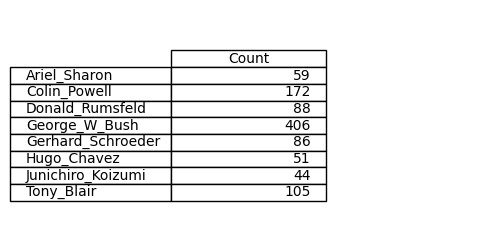

X_train (1011, 160, 160), X_test (337, 160, 160), y_train 1011, y_test 337, X_train dtype uint8, y_train dtype <class 'str'>


In [38]:
def load_dataset(directory, batch_size=1000, min_faces=0):
  train_x, train_y, test_x, test_y = [],[], [],[]
  batch_num = 0

  # add slash to end of dir path
  if directory[-1] != '/':
    directory += '/'

  for i, subdir in enumerate(listdir(directory)):

    path = directory + subdir + '/'
    #load all faces in subdirectory
    faces = [asarray(Image.open(path + img_name).convert("L")) for img_name in listdir(path)]
    if min_faces > 0 and len(faces) < min_faces:
      continue

    train_y.extend([subdir for _ in range(len(faces))])
    train_x.extend(faces)

  return np.array(train_x), train_y

data, labels = load_dataset('/content/mtcnn_extracted_faces/', 1000, 60)
print(f"{data.shape}, {len(labels)}")
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)


##### Plot a table of the dataset #######
y_frame=pd.DataFrame()
y_frame['subject ids']=y_train
table = pd.crosstab(index=y_frame['subject ids'], columns='count')
fig, ax = plt.subplots(figsize=(2, 3))
ax.axis('off')  # Turn off axis labels and ticks
# Create a table plot
table_plot = ax.table(cellText=table.values,
                      colLabels=['Count'],
                      rowLabels=table.index,
                      loc='left')
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
plt.show()

savez_compressed("/content/dataset.npz" ,X_train, y_train, X_test, y_test)
print(f"X_train {X_train.shape}, X_test {X_test.shape}, y_train {len(y_train)}, y_test {len(y_test)}, X_train dtype {X_train.dtype}, y_train dtype {type(y_train[0])}")


In [39]:
unq_labels = []
for label in y_train:
  if label not in unq_labels:
    unq_labels.append(label)
for label in y_test:
  if label not in unq_labels:
    unq_labels.append(label)
print(f'Number of Classes: {len(unq_labels)}')

Number of Classes: 8


(1011,)
(337,)
LabelEncoder Classes: ['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Junichiro_Koizumi' 'Tony_Blair']
X_train (1011, 150), X_test (337, 150), y_train (1011,), y_test (337,), X_train dtype float64, y_train dtype float64


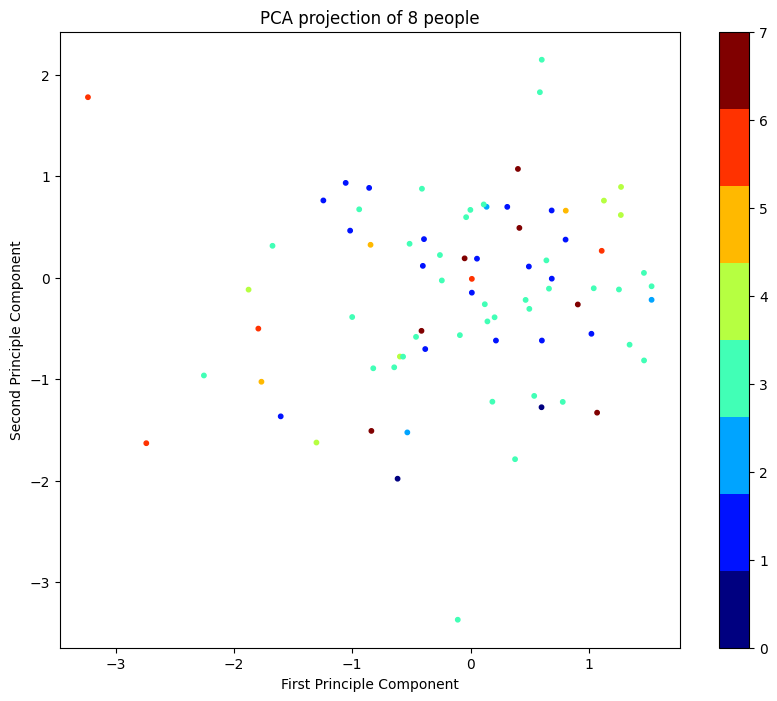

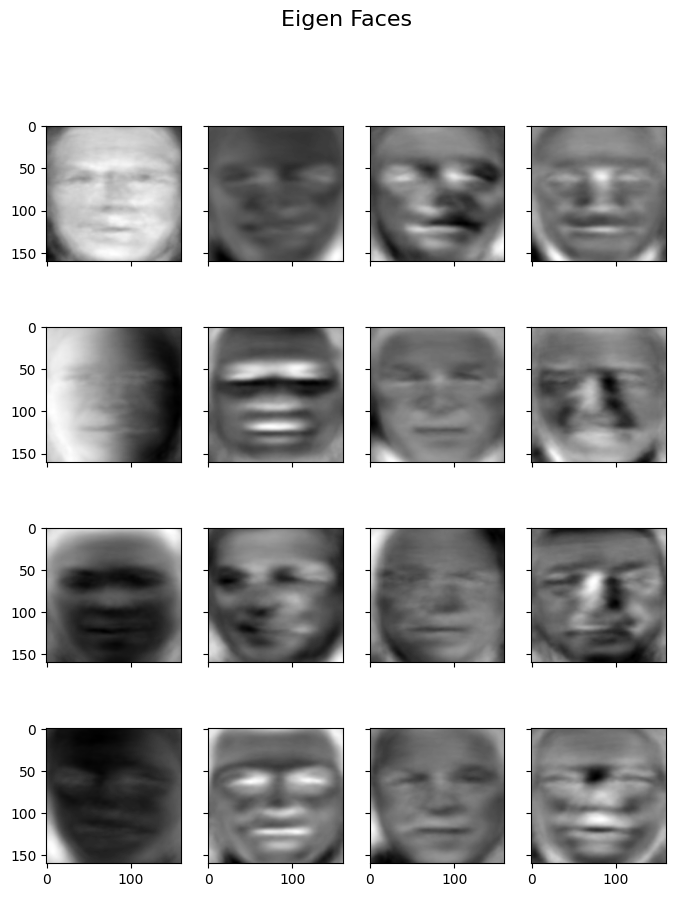

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearSVC from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


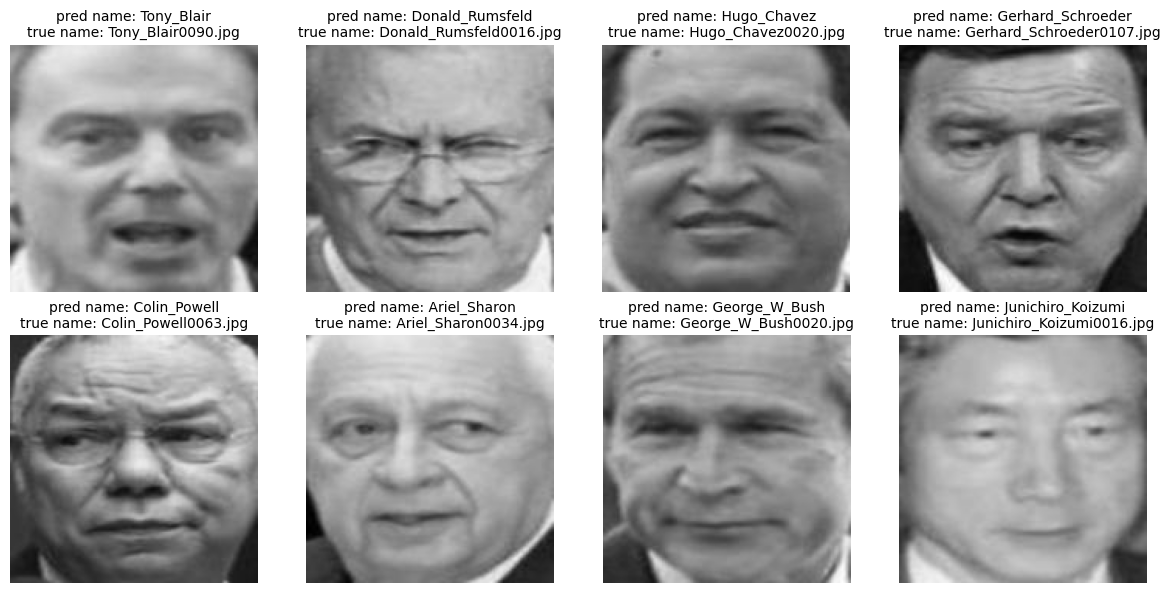

In [40]:
# Load the compressed dataset and embeddings
pca_generator = LFW_IncrementalPCA(['/content/dataset.npz'], 150)
pca_generator.start_fit()
train_X, train_Y, test_X, test_Y = pca_generator.get_embeddings()
print(f"X_train {train_X.shape}, X_test {test_X.shape}, y_train {train_Y.shape}, y_test {test_Y.shape}, X_train dtype {train_X.dtype}, y_train dtype {test_Y.dtype}")


pca_generator.plot_projection_n_target()
pca_generator.show_eigen_faces()

testimages_path = "/content/testimages"
our_pca_svm_model = joblib.load("/content/our_linearsvc_pca_model.pkl")
pca_generator.predict_result(testimages_path, our_pca_svm_model)



In [152]:
import pickle
with open('incremental_pca_model.pkl', 'wb') as file:
    pickle.dump(pca_generator, file)

savez_compressed('pca_svm_embeddings_0001.npz', train_X, train_Y, test_X, test_Y)

In [143]:
import joblib
#Linear SVC Results

model=LinearSVC(C=10)

pipe = Pipeline([('scaler', MinMaxScaler_C()), ('pca', model)])

#MinMaxScaling
scaler=MinMaxScaler_C().fit(train_X)
trainx =scaler.transform(train_X)
testx = scaler.transform(test_X)

#encode labels
label_encoder = LabelEncoder_C().fit(train_Y)
true_training_labels_encoded = label_encoder.transform(train_Y)

model.fit(trainx,true_training_labels_encoded)


#predict
predict_train = model.predict(trainx)
predict_test = model.predict(testx)

#Accuracy
true_test_labels_encoded = label_encoder.transform(test_Y)
acc_train = accuracy_score(true_training_labels_encoded,predict_train)
acc_test = accuracy_score(true_test_labels_encoded,predict_test)


print(acc_train)
print(acc_test)

#save your model or results
joblib.dump(model, 'our_linearsvc_pca_model.pkl')


0.9821958456973294
0.8160237388724035


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['our_linearsvc_pca_model.pkl']